In [8]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy.linalg import LinAlgError
import seaborn as sns

In [9]:
def moore_penrose_pseudoinv(X):
    return np.linalg.inv(X.T @ X) @ X.T


def W_alpha_task(X_s, X_q, alpha):
    assert (X_s.shape == X_q.shape)
    n = X_s.shape[0]
    p = X_s.shape[1]
    return (np.eye(p) - (alpha/n) * X_s.T @ X_s) @ X_q.T
    
    
def Z_alpha_task(X_s, y_s, X_q, y_q, alpha):
    assert (X_s.shape == X_q.shape)
    assert (y_s.shape == y_q.shape)
    n = X_s.shape[0]
    return y_q - (alpha/n) * X_q @ (X_s.T @ y_s)


def grad_task(X_s, y_s, theta):
    n = X_s.shape[0]
    return (1./n) * ((X_s.T @ X_s) @ theta - X_s.T @ y_s)


def adapt_task(X_s, y_s, theta, alpha):
    return theta - alpha * grad_task(X_s, y_s, theta)

In [35]:
def sample_task(n, p, X_s_fixed=None, get_mean=False):
    
    theta_t = np.random.uniform(0.05, 3., size=(p))
    X_mean = np.abs(theta_t)
    Q_t = V_t @ np.diag(1./np.abs(theta_t)) @ V_t.T
    sigma_t = np.random.uniform(0, np.sqrt(0.25))
    
    # support
    e_s = np.random.normal(size=(n)) * sigma_t    
    if X_s_fixed is None:
        X_s = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    else:
        X_s = X_s_fixed
    y_s = X_s @ theta_t + e_s
    
    # query
    e_q = np.random.normal(size=(n)) * sigma_t
    X_q = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    y_q = X_q @ theta_t + e_q
    
    if get_mean:
        meanX = [np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)]) for _ in range(100)]
        meanX = np.mean(np.stack(meanX, axis=0), axis=0)
        return (X_s, y_s, X_q, y_q, theta_t), meanX
    else:
        return X_s, y_s, X_q, y_q, theta_t



def sample_task_from_predefined_set_of_task_params(n, p, task_param_set, X_s_pool=None):
    
    idx = np.random.choice(len(task_param_set))
    theta_t = task_param_set[idx]
    X_s_fixed = None
    if X_s_pool is not None:
        X_s_fixed = X_s_pool[idx]
       
    
    X_mean = np.abs(1./theta_t)
    Q_t = V_t @ np.diag(1./np.abs(theta_t)) @ V_t.T
    sigma_t = np.random.uniform(0, np.sqrt(0.25))
    
    # support
    e_s = np.random.normal(size=(n)) * sigma_t    
    if X_s_fixed is None:
        X_s = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    else:
        X_s = X_s_fixed
    y_s = X_s @ theta_t + e_s
    
    # query
    e_q = np.random.normal(size=(n)) * sigma_t
    X_q = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    y_q = X_q @ theta_t + e_q
    
    return X_s, y_s, X_q, y_q, theta_t


def evaluate_theta_over_multiple_tasks(theta_hat, alpha, n, X_s_fixed):
    p = len(theta_hat)
    M = 2000
    risk = []
    for _ in range(M):
        X_s, y_s, X_q, y_q, _ = sample_task(n, p, X_s_fixed)
        theta_hat_t = adapt_task(X_s, y_s, theta_hat, alpha)
        risk.append(np.mean((X_q @ theta_hat_t - y_q)**2))
    return np.mean(risk)

In [11]:
def main_predefined_set(n_runs, M, n, p, alpha, predefined_set_sz):

    seed = np.random.choice(100)
    
    task_param_set = []
    X_s_pool = []
    for _ in range(predefined_set_sz):
        task, mean = sample_task(n, p, get_mean=True)
        X_s_pool.append(mean)
        task_param_set.append(task[-1])
    
    np.random.seed(seed)
    runs_ml = []
    for _ in tqdm(range(n_runs)):
        # Single Run
        W_alpha = []
        Z_alpha = []
        # iterate over tasks
        for _ in range(M):
            X_s, y_s, X_q, y_q, _ = sample_task_from_predefined_set_of_task_params(n, p, task_param_set=task_param_set)
            W_alpha.append(W_alpha_task(X_s, X_q, alpha).T)
            Z_alpha.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
        W_alpha = np.concatenate(W_alpha, axis=0)
        Z_alpha = np.concatenate(Z_alpha, axis=0)
        argmin_theta_empirical = moore_penrose_pseudoinv(W_alpha) @ Z_alpha
        runs_ml.append(evaluate_theta_over_multiple_tasks(argmin_theta_empirical, alpha=alpha, n=n, X_s_fixed=None))


    np.random.seed(seed)
    runs_fixml = []
    for _ in tqdm(range(n_runs)):
        # Single FixML Run
        W_alpha = []
        Z_alpha = []
        for _ in range(M):
            X_s, y_s, X_q, y_q, _ = sample_task_from_predefined_set_of_task_params(n, p, task_param_set=task_param_set, X_s_pool=X_s_pool)
            W_alpha.append(W_alpha_task(X_s, X_q, alpha).T)
            Z_alpha.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
        W_alpha = np.concatenate(W_alpha, axis=0)
        Z_alpha = np.concatenate(Z_alpha, axis=0)
        argmin_theta_empirical = moore_penrose_pseudoinv(W_alpha) @ Z_alpha
        runs_fixml.append(evaluate_theta_over_multiple_tasks(argmin_theta_empirical, alpha=alpha, n=n, X_s_fixed=None))

    return runs_ml, runs_fixml

In [39]:
seed = np.random.choice(100)
alpha = 0.3 # inner loop lr
M=1000 # M is no. of tasks to sample
predefined_set_sz = 200 # fixed number of task types
n=3 # n is no. of support/query samples in a task
p=7 # p is ambient dimension
V_t = np.stack([np.random.normal(size=(p)) for _ in range(p)], axis=0).T
V_t = np.linalg.qr(V_t)[0]



task_param_set = []
X_s_pool = []
for _ in range(predefined_set_sz):
    task, mean = sample_task(n, p, get_mean=True)
    X_s_pool.append(mean)
    task_param_set.append(task[-1])

    
np.random.seed(seed)
# Single Run
W_alpha = []
Z_alpha = []
# iterate over tasks
for _ in range(M):
    X_s, y_s, X_q, y_q, _ = sample_task_from_predefined_set_of_task_params(n, p, task_param_set=task_param_set)
    W_alpha.append(W_alpha_task(X_s, X_q, alpha).T)
    Z_alpha.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
W_alpha = np.concatenate(W_alpha, axis=0)
Z_alpha = np.concatenate(Z_alpha, axis=0)
argmin_theta_empirical = moore_penrose_pseudoinv(W_alpha) @ Z_alpha
print(evaluate_theta_over_multiple_tasks(argmin_theta_empirical, alpha=alpha, n=n, X_s_fixed=None))

        
        
np.random.seed(seed)
# Single FixML Run
W_alpha = []
Z_alpha = []
for _ in range(M):
    X_s, y_s, X_q, y_q, _ = sample_task_from_predefined_set_of_task_params(n, p, task_param_set=task_param_set, X_s_pool=X_s_pool)
    W_alpha.append(W_alpha_task(X_s, X_q, alpha).T)
    Z_alpha.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
W_alpha = np.concatenate(W_alpha, axis=0)
Z_alpha = np.concatenate(Z_alpha, axis=0)
argmin_theta_empirical = moore_penrose_pseudoinv(W_alpha) @ Z_alpha
print(evaluate_theta_over_multiple_tasks(argmin_theta_empirical, alpha=alpha, n=n, X_s_fixed=None))

74.36209632003703
47.93966947065389


Running T2 M=1000 n=3 p=7 alpha=0.3 predefined_set_sz=200


100%|██████████| 50/50 [02:03<00:00,  2.47s/it]


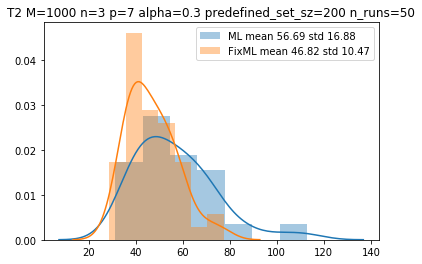

In [41]:
n_runs=50
seed = np.random.choice(100)
alpha = 0.3 # inner loop lr
M=1000 # M is no. of tasks to sample
predefined_set_sz = 200 # fixed number of task types
n=3 # n is no. of support/query samples in a task
p=7 # p is ambient dimension
V_t = np.stack([np.random.normal(size=(p)) for _ in range(p)], axis=0).T
V_t = np.linalg.qr(V_t)[0]

# M is no. of tasks to sample
# n is no. of support/query samples in a task
# p is ambient dimension
# predefined_set_sz is the type of total tasks

print(f"Running T2 M={M} n={n} p={p} alpha={alpha} predefined_set_sz={predefined_set_sz}")
fig = plt.figure()
runs_ml, runs_fixml=main_predefined_set(M=M, n=n, p=p, alpha=alpha, n_runs=n_runs, predefined_set_sz=predefined_set_sz)
sns.distplot(runs_ml, label='ML mean %.2f std %.2f' % (np.mean(runs_ml), np.std(runs_ml)))
sns.distplot(runs_fixml, label='FixML mean %.2f std %.2f' % (np.mean(runs_fixml), np.std(runs_fixml)))
plt.title(f"T2 M={M} n={n} p={p} alpha={alpha} predefined_set_sz={predefined_set_sz} n_runs={n_runs}")
plt.legend()
plt.savefig(f"predefined_set_sz={predefined_set_sz}_T2_res_M={M}_n={n}_p={p}_alpha={alpha}_n_runs={n_runs}.png")